In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "AppleGothic"
import seaborn as sns
import sklearn as skl
import librosa

from fma_related.fma import utils

In [2]:
# Load metadata and features.
raw_tracks = utils.load('./data/fma_metadata/tracks.csv')
raw_genres = utils.load('./data/fma_metadata/genres.csv')
raw_features = utils.load('./data/fma_metadata/features.csv')
raw_echonest = utils.load('./data/fma_metadata/echonest.csv')

raw_tracks.shape, raw_genres.shape, raw_features.shape, raw_echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [3]:
tracks = raw_tracks.copy()
features = raw_features.copy()

In [4]:
# flatten_columns

tracks.columns = list(map("_".join, tracks.columns))
features.columns = list(map("_".join, features.columns))

In [5]:
tracks["track_genre_top"].value_counts().nlargest(5)

track_genre_top
Rock            14182
Experimental    10608
Electronic       9372
Hip-Hop          3552
Folk             2803
Name: count, dtype: int64

In [6]:
using_genres = tracks["track_genre_top"].value_counts().nlargest(5).index
using_tracks = tracks[tracks["track_genre_top"].isin(using_genres)]

raw_train_set = using_tracks.loc[:, ["track_genre_top"]].merge(
    features, right_index=True, left_index=True
)
raw_train_set["track_genre_top"] = raw_train_set["track_genre_top"].astype(str)
raw_train_set = raw_train_set.loc[
    :, filter(lambda x: not x.startswith("rmse"), raw_train_set.columns)
]

In [7]:
# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [8]:
# visualizer
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [9]:
# 5 label classification raw
le5_train_set = raw_train_set.copy()

le5 = LabelEncoder()
le5_train_set["track_genre_top"] = le5.fit_transform(le5_train_set["track_genre_top"].to_numpy())

x = le5_train_set.drop(columns=["track_genre_top"])
y = le5_train_set.loc[:, "track_genre_top"]

x_train, x_validate, y_train, y_validate = train_test_split(x, y)

le5_svc = SVC()
le5_dtc = DecisionTreeClassifier()
le5_rfc = RandomForestClassifier()

le5_svc.fit(x_train, y_train)
le5_dtc.fit(x_train, y_train)
le5_rfc.fit(x_train, y_train)

svc_pred_y_val = le5_svc.predict(x_validate)
dtc_pred_y_val = le5_dtc.predict(x_validate)
rfc_pred_y_val = le5_rfc.predict(x_validate)

print(accuracy_score(svc_pred_y_val, y_validate))
print(accuracy_score(dtc_pred_y_val, y_validate))
print(accuracy_score(rfc_pred_y_val, y_validate))

0.5511352418558736
0.5569595261599211
0.721618953603159


# ACC 0.713

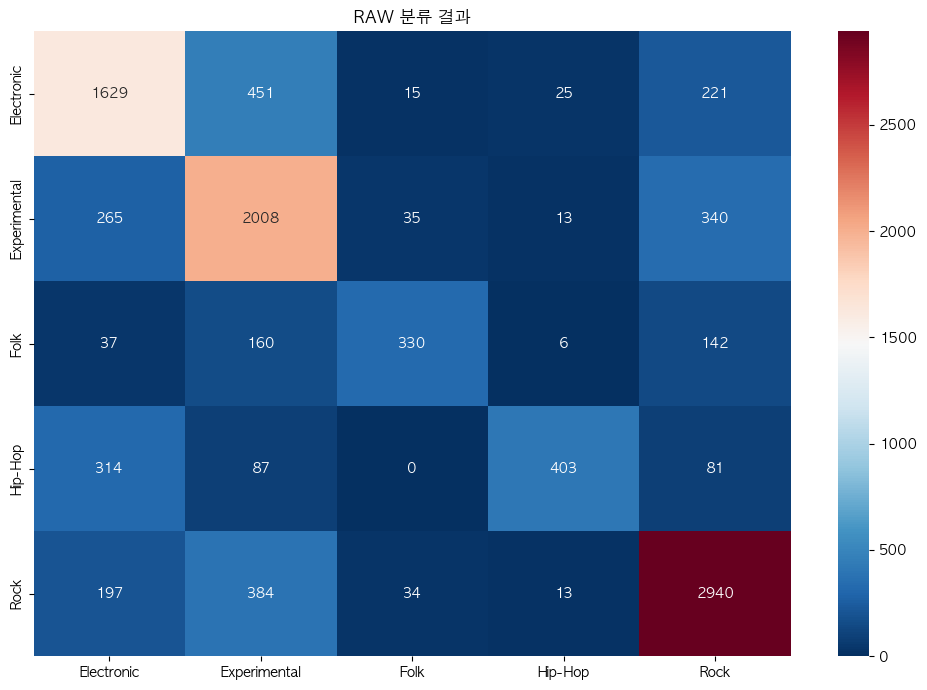

In [10]:
plt.figure(figsize=(10, 7))
sns.heatmap(
    pd.DataFrame(
        confusion_matrix(
            le5.inverse_transform(y_validate),
            le5.inverse_transform(rfc_pred_y_val),
            labels=le5.classes_,
        ),
        columns=le5.classes_,
        index=le5.classes_,
    ),
    fmt='d',
    annot=True,
    cmap="RdBu_r",
)
plt.title("RAW 분류 결과")
plt.tight_layout()
plt.show()

In [11]:
# 5 label classification stratified
le5_stratified_train_set = le5_train_set.groupby("track_genre_top", group_keys=False).apply(
    lambda x: x.sample(2800)
)

x = le5_stratified_train_set.drop(columns=["track_genre_top"])
y = le5_stratified_train_set.loc[:, "track_genre_top"]

x_train, x_validate, y_train, y_validate = train_test_split(x, y)

le5_svc.fit(x_train, y_train)
le5_dtc.fit(x_train, y_train)
le5_rfc.fit(x_train, y_train)

svc_pred_y_val = le5_svc.predict(x_validate)
dtc_pred_y_val = le5_dtc.predict(x_validate)
rfc_pred_y_val = le5_rfc.predict(x_validate)

print(accuracy_score(svc_pred_y_val, y_validate))
print(accuracy_score(dtc_pred_y_val, y_validate))
print(accuracy_score(rfc_pred_y_val, y_validate))

0.46085714285714285
0.5111428571428571
0.678


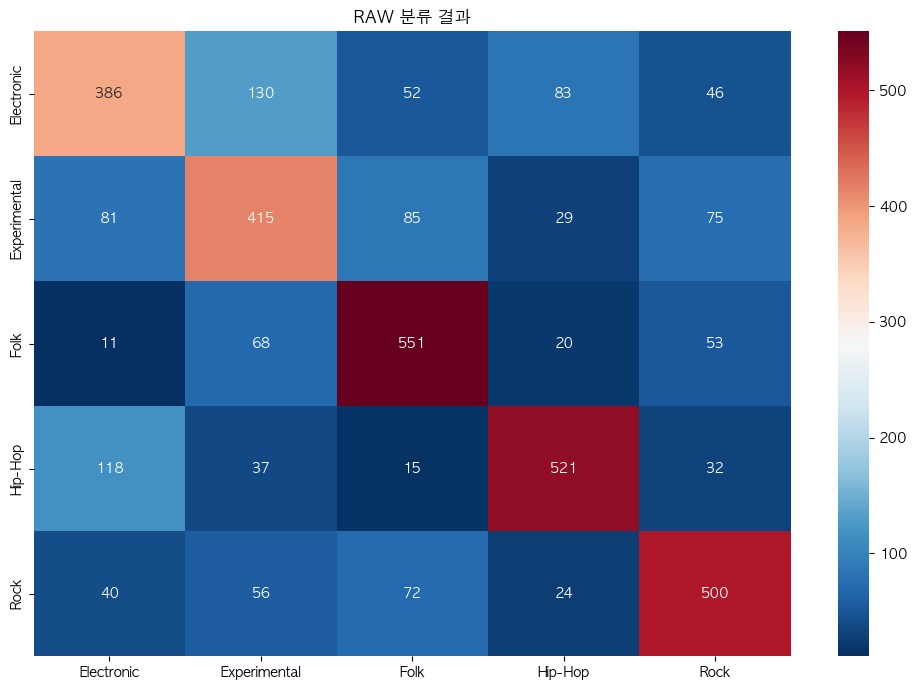

In [12]:
plt.figure(figsize=(10, 7))
sns.heatmap(
    pd.DataFrame(
        confusion_matrix(
            le5.inverse_transform(y_validate),
            le5.inverse_transform(rfc_pred_y_val),
            labels=le5.classes_,
        ),
        columns=le5.classes_,
        index=le5.classes_,
    ),
    fmt="d",
    annot=True,
    cmap="RdBu_r",
)
plt.title("RAW 분류 결과")
plt.tight_layout()
plt.show()

In [13]:
le5_rfc.fit(x, y)

RandomForestClassifier()

In [14]:
with open("./models/le5_le.pkl", "wb") as f:
    pickle.dump(le5, f)

with open("./models/le5_rfc.pkl", "wb") as f:
    pickle.dump(le5_rfc, f)

In [15]:
# 3 label(hiphop / experimenetal / etc) classification stratified

## pps
le3_train_set = raw_train_set.copy()

etc_condition = le3_train_set["track_genre_top"].isin(["Hip-Hop", "Experimental"])
le3_train_set.loc[~etc_condition, "track_genre_top"] = "etc"

#
le3 = LabelEncoder()
le3_train_set["track_genre_top"] = le3.fit_transform(le3_train_set["track_genre_top"].to_numpy())

#
le3_train_set = le3_train_set.groupby("track_genre_top", group_keys=False).apply(
    lambda x: x.sample(3500)
)

x = le3_train_set.drop(columns=["track_genre_top"])
y = le3_train_set.loc[:, "track_genre_top"]

x_train, x_validate, y_train, y_validate = train_test_split(x, y)

le3_svc = SVC()
le3_dtc = DecisionTreeClassifier()
le3_rfc = RandomForestClassifier()

le3_svc.fit(x_train, y_train)
le3_dtc.fit(x_train, y_train)
le3_rfc.fit(x_train, y_train)

svc_pred_y_val = le3_svc.predict(x_validate)
dtc_pred_y_val = le3_dtc.predict(x_validate)
rfc_pred_y_val = le3_rfc.predict(x_validate)

print(accuracy_score(svc_pred_y_val, y_validate))
print(accuracy_score(dtc_pred_y_val, y_validate))
print(accuracy_score(rfc_pred_y_val, y_validate))

0.5733333333333334
0.603047619047619
0.7398095238095238


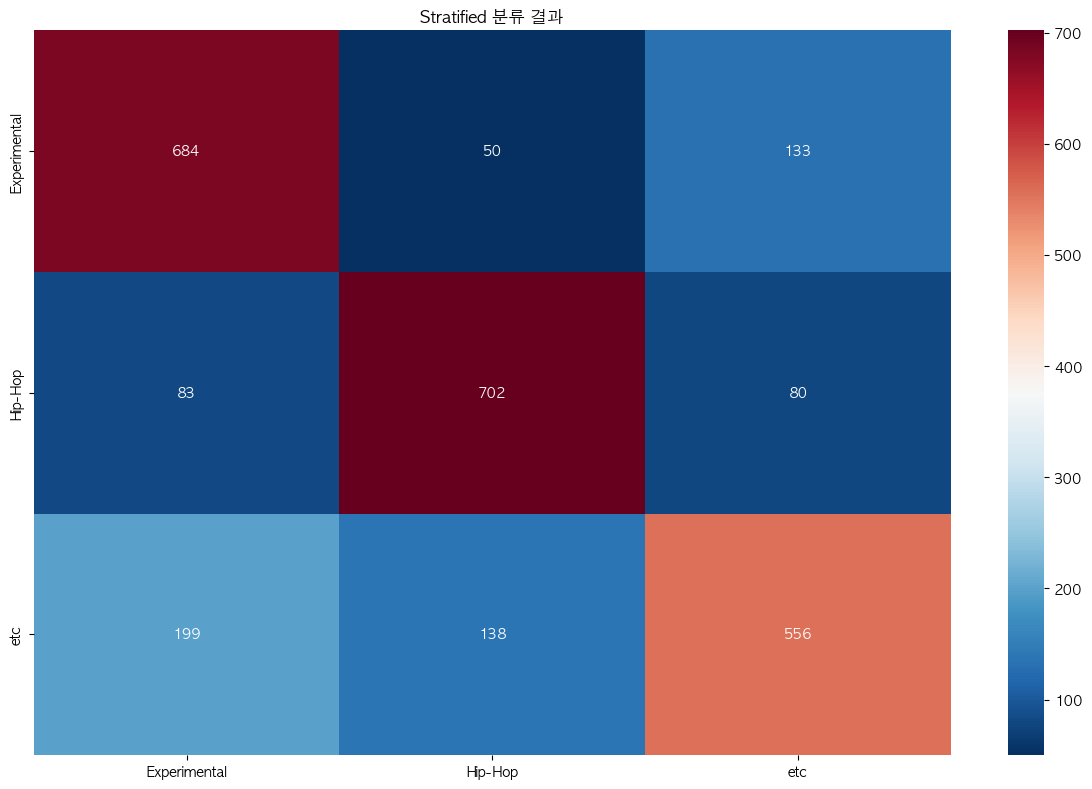

In [16]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    pd.DataFrame(
        confusion_matrix(
            le3.inverse_transform(y_validate),
            le3.inverse_transform(rfc_pred_y_val),
            labels=le3.classes_,
        ),
        columns=le3.classes_,
        index=le3.classes_,
    ),
    fmt='d',
    annot=True,
    cmap="RdBu_r",
)
plt.title("Stratified 분류 결과")
plt.tight_layout()
plt.show()

In [17]:
le3_rfc.fit(x, y)

RandomForestClassifier()

In [18]:
with open("./models/le3_le.pkl", "wb") as f:
    pickle.dump(le3, f)

with open("./models/le3_rfc.pkl", "wb") as f:
    pickle.dump(le3_rfc, f)

In [19]:
# 2 label classification

## pps
le2_train_set = raw_train_set.copy()

nothiphop_condition = le2_train_set["track_genre_top"] != 'Hip-Hop'
le2_train_set.loc[nothiphop_condition,'track_genre_top'] = "Not-Hip-Hop"

#
le2 = LabelEncoder()
le2_train_set["track_genre_top"] = le2.fit_transform(le2_train_set["track_genre_top"].to_numpy())

#
le2_train_set = le2_train_set.groupby("track_genre_top", group_keys=False).apply(
    lambda x: x.sample(3500)
)

x = le2_train_set.drop(columns=["track_genre_top"])
y = le2_train_set.loc[:, "track_genre_top"]

x_train, x_validate, y_train, y_validate = train_test_split(x, y)

le2_svc = SVC()
le2_dtc = DecisionTreeClassifier()
le2_rfc = RandomForestClassifier()

le2_svc.fit(x_train, y_train)
le2_dtc.fit(x_train, y_train)
le2_rfc.fit(x_train, y_train)

svc_pred_y_val = le2_svc.predict(x_validate)
dtc_pred_y_val = le2_dtc.predict(x_validate)
rfc_pred_y_val = le2_rfc.predict(x_validate)

print(accuracy_score(svc_pred_y_val, y_validate))
print(accuracy_score(dtc_pred_y_val, y_validate))
print(accuracy_score(rfc_pred_y_val, y_validate))

0.7148571428571429
0.7417142857142857
0.852


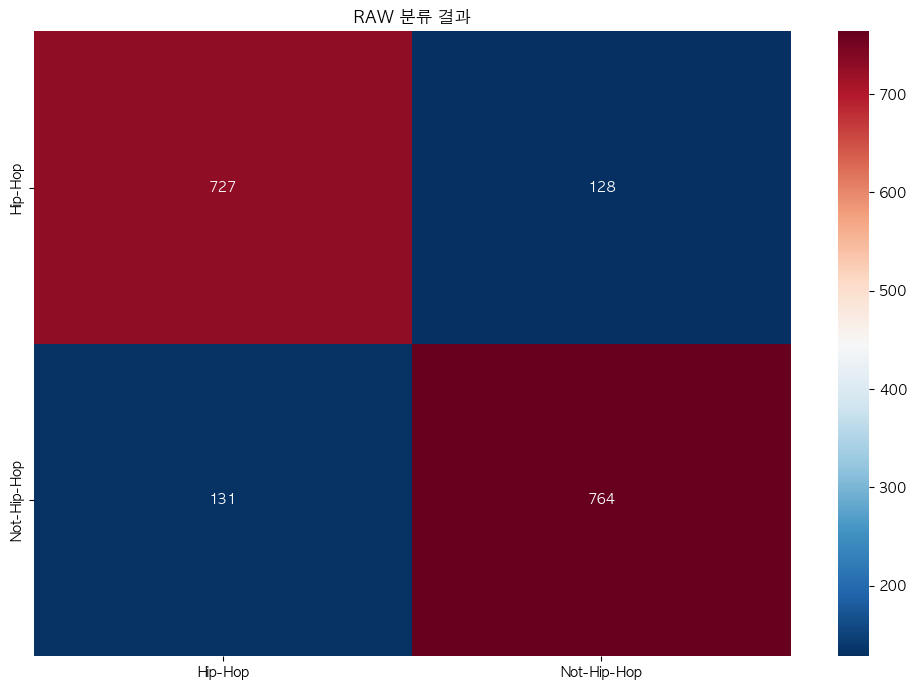

In [20]:
plt.figure(figsize=(10, 7))
sns.heatmap(
    pd.DataFrame(
        confusion_matrix(
            le2.inverse_transform(y_validate),
            le2.inverse_transform(rfc_pred_y_val),
            labels=le2.classes_,
        ),
        columns=le2.classes_,
        index=le2.classes_,
    ),
    fmt="d",
    annot=True,
    cmap="RdBu_r",
)
plt.title("RAW 분류 결과")
plt.tight_layout()
plt.show()

In [21]:
le2_rfc.fit(x, y)

RandomForestClassifier()

In [22]:
with open("./models/le2_le.pkl", "wb") as f:
    pickle.dump(le2, f)

with open("./models/le2_rfc.pkl", "wb") as f:
    pickle.dump(le2_rfc, f)